In [56]:
import yfinance as yf

import torch
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np

# Lista de ativos
ativos = {
    'Energia e Petróleo': ['PETR4.SA', 'ENEV3.SA', 'UGPA3.SA'],
    'Mineração': ['VALE3.SA', 'CMIN3.SA'],
    'Bancário': ['ITUB4.SA', 'BBAS3.SA', 'BBDC4.SA'],
    'Varejo': ['MGLU3.SA', 'VIIA3.SA'],
    'Alimentação': ['JBSS3.SA', 'BRFS3.SA','ABEV3.SA'],
}

# Configuração do período de tempo (5 anos)
start_date = '2018-07-09'
end_date = '2023-07-09'

# Dicionário para armazenar os dados
dados = {}

# Busca e armazenamento dos dados
for setor, tickers in ativos.items():
    dados[setor] = {}
    for ticker in tickers:
        acao = yf.download(ticker, start=start_date, end=end_date)
        dados[setor][ticker] = acao



# Exemplo de acesso aos dados
print(dados['Energia e Petróleo']['PETR4.SA'].head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 Open   High        Low      Close  Adj Close    Volume
Date                           

In [57]:


# Dicionário para armazenar os dados normalizados
dados_normalizados = {}

# Normalização e armazenamento dos dados
for setor, ativos_setor in dados.items():
    dados_normalizados[setor] = {}
    for ativo, df in ativos_setor.items():
        # Transformação dos preços de fechamento em tensores PyTorch
        close_prices = torch.Tensor(df['Adj Close'].values)

        # Normalização dos preços de fechamento
        normalized_close_prices = (close_prices - close_prices.min()) / (close_prices.max() - close_prices.min())

        # Armazenando os dados normalizados
        dados_normalizados[setor][ativo] = pd.DataFrame(normalized_close_prices.numpy(), 
                                                        index=df.index, 
                                                        columns=['Adj Close Normalized'])


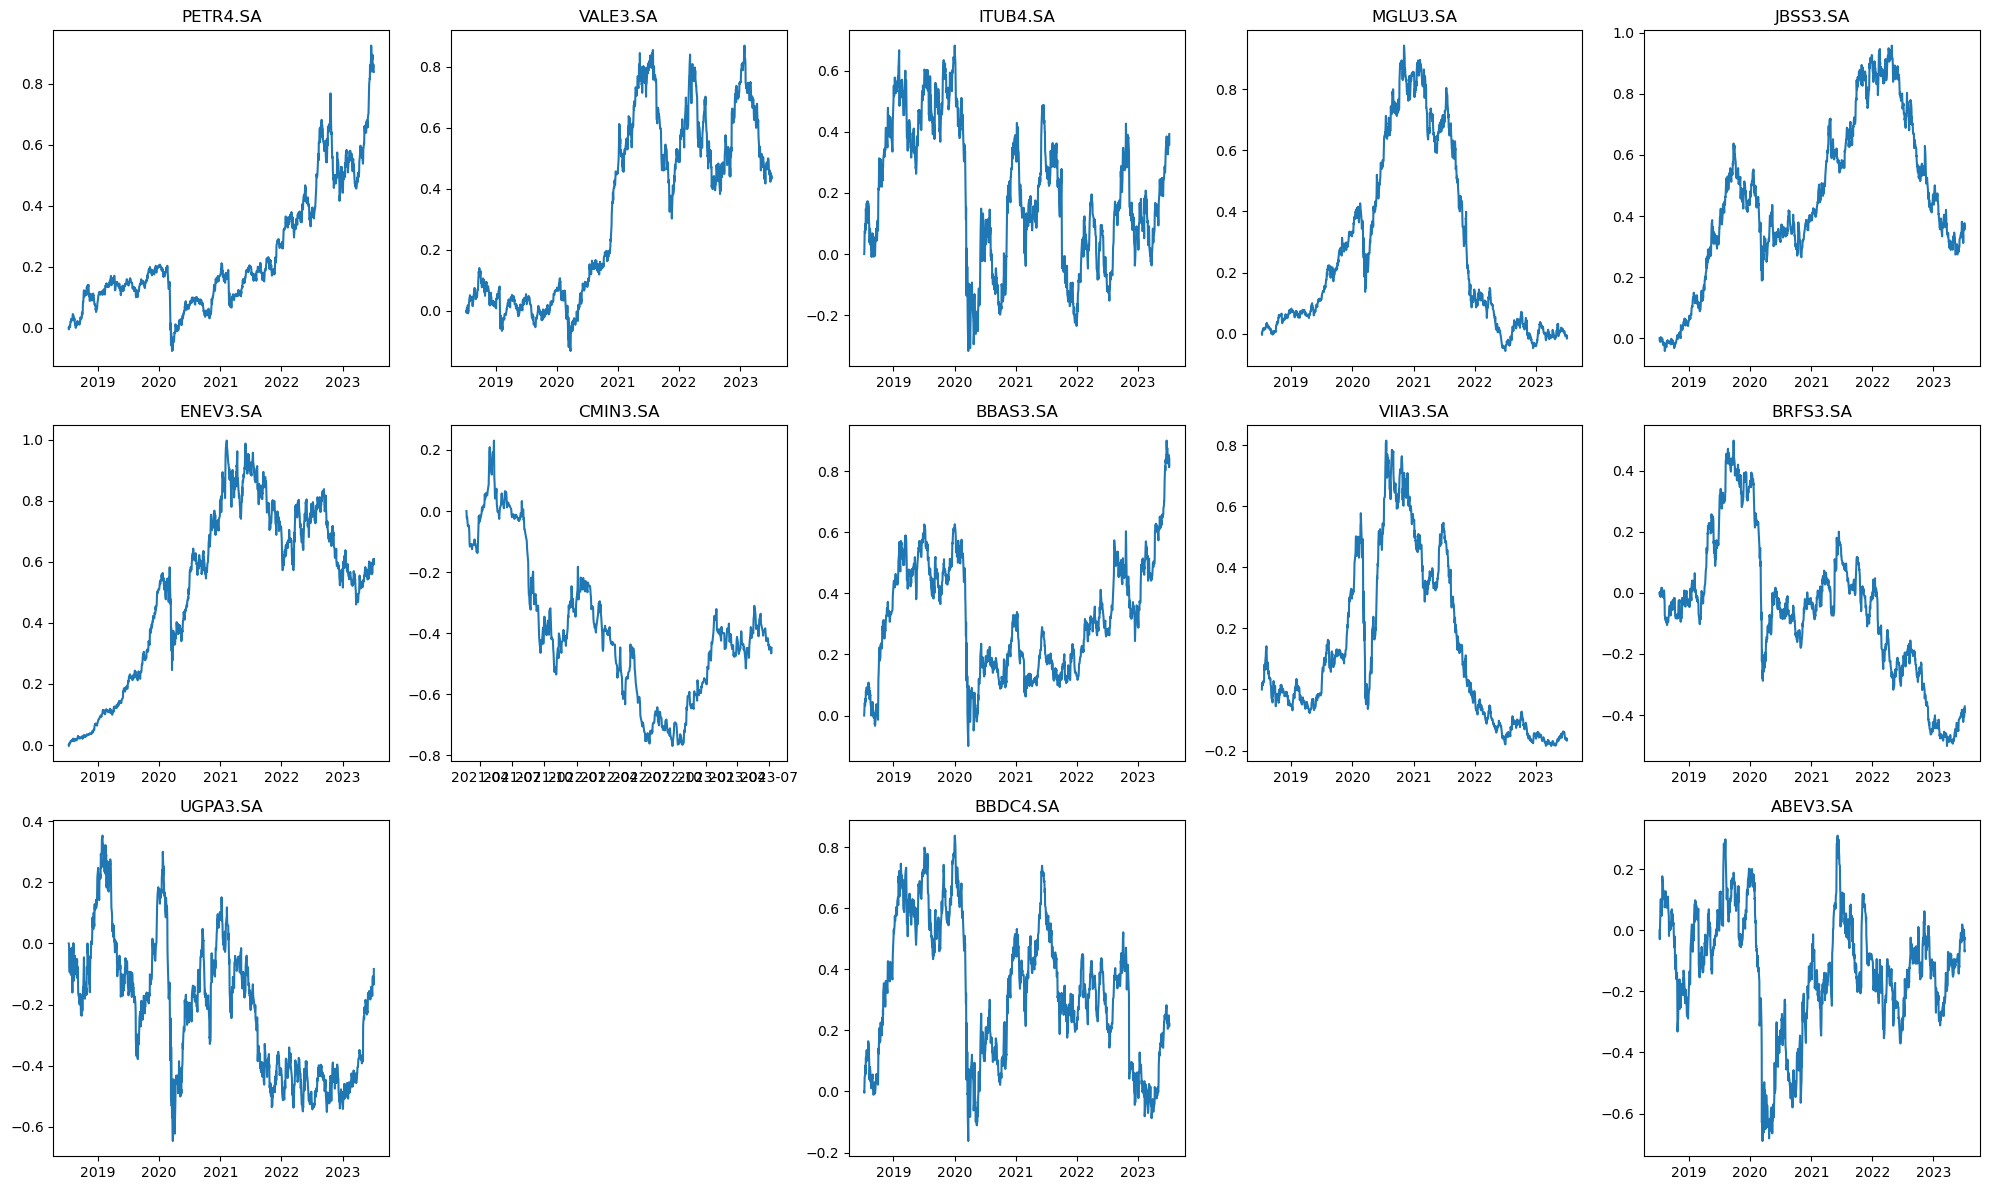

In [58]:
# Cálculo do número máximo de ativos em um setor
max_ativos = max([len(ativos_setor) for ativos_setor in dados_normalizados.values()])

# Criação da figura e dos subplots
fig, axs = plt.subplots(max_ativos, len(dados_normalizados), figsize=(4*len(dados_normalizados), 4*max_ativos))

# Desligando a visibilidade de todos os subplots por padrão
for ax in axs.flat:
    ax.axis('off')

# Plotagem dos dados normalizados
for j, (setor, ativos_setor) in enumerate(dados_normalizados.items()):
    for i, (ativo, df) in enumerate(ativos_setor.items()):
        # Ligando a visibilidade do subplot correspondente
        axs[i, j].axis('on')

        # Normalização adicional para que todos os gráficos comecem de 0
        df = df - df.iloc[0]

        # Plotagem dos dados
        axs[i, j].plot(df.index, df['Adj Close Normalized'], label=ativo)

        # Definição do título do subplot
        axs[i, j].set_title(ativo)

# Ajuste automático do layout
plt.tight_layout()

# Exibição da figura
plt.show()


In [59]:
# Salvar os dados normalizados
with open('dados_normalizados.pkl', 'wb') as f:
    pickle.dump(dados_normalizados, f)

# Carregar os dados normalizados
with open('dados_normalizados.pkl', 'rb') as f:
    dados_normalizados = pickle.load(f)

# Criar os conjuntos de dados de treino, teste e avaliação final
dados_treino = {}
dados_teste = {}
dados_avaliacao_final = {}

for setor, ativos_setor in dados_normalizados.items():
    dados_treino[setor] = {}
    dados_teste[setor] = {}
    dados_avaliacao_final[setor] = {}

    for ativo, df in ativos_setor.items():
        # Separar os dados para a avaliação final
        aval_final = df.loc['2023-01-01':'2023-07-09']
        dados_avaliacao_final[setor][ativo] = aval_final

        # Dados restantes
        dados_restantes = df.loc[:'2022-12-31']

        # Dividir os dados restantes em treino e teste
        tamanho_treino = int(len(dados_restantes) * 0.8)
        dados_treino[setor][ativo] = dados_restantes[:tamanho_treino]
        dados_teste[setor][ativo] = dados_restantes[tamanho_treino:]

# Salvar os conjuntos de dados
with open('dados_treino.pkl', 'wb') as f:
    pickle.dump(dados_treino, f)

with open('dados_teste.pkl', 'wb') as f:
    pickle.dump(dados_teste, f)

with open('dados_avaliacao_final.pkl', 'wb') as f:
    pickle.dump(dados_avaliacao_final, f)



In [60]:
# Carregar os dados
with open('dados_treino.pkl', 'rb') as f:
    dados_treino = pickle.load(f)

with open('dados_teste.pkl', 'rb') as f:
    dados_teste = pickle.load(f)

with open('dados_avaliacao_final.pkl', 'rb') as f:
    dados_avaliacao_final = pickle.load(f)

# Listar os primeiros registros de treino
for setor, setor_dados in dados_treino.items():
    print(f"Setor: {setor}")
    for ticker, df in setor_dados.items():
        print(f"\nAtivo: {ticker}")
        print(df.head())

# Listar os primeiros registros de teste
for setor, setor_dados in dados_teste.items():
    print(f"Setor: {setor}")
    for ticker, df in setor_dados.items():
        print(f"\nAtivo: {ticker}")
        print(df.head())

# Listar os primeiros registros de avaliação final
for setor, setor_dados in dados_avaliacao_final.items():
    print(f"Setor: {setor}")
    for ticker, df in setor_dados.items():
        print(f"\nAtivo: {ticker}")
        print(df.head())


Setor: Energia e Petróleo

Ativo: PETR4.SA
            Adj Close Normalized
Date                            
2018-07-10              0.075533
2018-07-11              0.070951
2018-07-12              0.078228
2018-07-13              0.080384
2018-07-16              0.077285

Ativo: ENEV3.SA
            Adj Close Normalized
Date                            
2018-07-10              0.003175
2018-07-11              0.000000
2018-07-12              0.002381
2018-07-13              0.008730
2018-07-16              0.007143

Ativo: UGPA3.SA
            Adj Close Normalized
Date                            
2018-07-10              0.646819
2018-07-11              0.644364
2018-07-12              0.639999
2018-07-13              0.574250
2018-07-16              0.552698
Setor: Mineração

Ativo: VALE3.SA
            Adj Close Normalized
Date                            
2018-07-10              0.131233
2018-07-11              0.124728
2018-07-12              0.140164
2018-07-13              0.13880

In [61]:
print(dados['Energia e Petróleo']['PETR4.SA'].head())
print(dados_normalizados['Energia e Petróleo']['PETR4.SA'].head())


                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2018-07-10  18.340000  18.35  17.549999  17.750000   6.546657  70886200
2018-07-11  17.490000  18.08  17.299999  17.410000   6.421256  85806300
2018-07-12  17.620001  18.02  17.520000  17.950001   6.620422  49397900
2018-07-13  17.990000  18.18  17.780001  18.110001   6.679434  44951900
2018-07-16  17.950001  17.98  17.600000  17.879999   6.594604  62798900
            Adj Close Normalized
Date                            
2018-07-10              0.075533
2018-07-11              0.070951
2018-07-12              0.078228
2018-07-13              0.080384
2018-07-16              0.077285


In [62]:

# Calcular os retornos diários
retornos = {}
for setor in dados:
    for acao, dataframe in dados[setor].items():
        dataframe['Retorno'] = dataframe['Close'].pct_change()
        retornos[acao] = dataframe['Retorno']
        
retornos_df = pd.DataFrame(retornos)
retornos_df.dropna(inplace=True)

# Calcular os retornos anuais
retornos_anuais = retornos_df.mean() * 252


In [63]:
def portfolio_performance(weights, returns, covariance_matrix):
    portf_return = np.sum(returns * weights)
    portf_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portf_return, portf_volatility

In [64]:
# Calcular a matriz de covariância dos retornos
cov_matrix = retornos_df.cov() * 252

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [65]:
np.random.seed(42)
num_portfolios = 50000
num_stocks = len(retornos_anuais)

weights_record = []
sharpe_record = []

for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    returns, volatility = portfolio_performance(weights, retornos_anuais, cov_matrix)
    sharpe_ratio = returns / volatility
    sharpe_record.append(sharpe_ratio)

sharpe_array = np.array(sharpe_record)
weights_array = np.array(weights_record)
best_portfolio_idx = np.argmax(sharpe_array)
best_weights = weights_array[best_portfolio_idx]

# Print dos melhores pesos
for i in range(len(best_weights)):
    print(f'{retornos_anuais.index[i]} peso: {best_weights[i]}')

PETR4.SA peso: 0.18884777020769108
ENEV3.SA peso: 0.02013821061745547
UGPA3.SA peso: 0.03572003924159015
VALE3.SA peso: 0.06499355808427751
CMIN3.SA peso: 0.02938330453043086
ITUB4.SA peso: 0.07765378875660399
BBAS3.SA peso: 0.17414234947177462
BBDC4.SA peso: 0.01519836603228547
MGLU3.SA peso: 0.01290717007385184
VIIA3.SA peso: 0.001700756584559942
JBSS3.SA peso: 0.12862837211152137
BRFS3.SA peso: 0.01892216540258399
ABEV3.SA peso: 0.2317641488853736


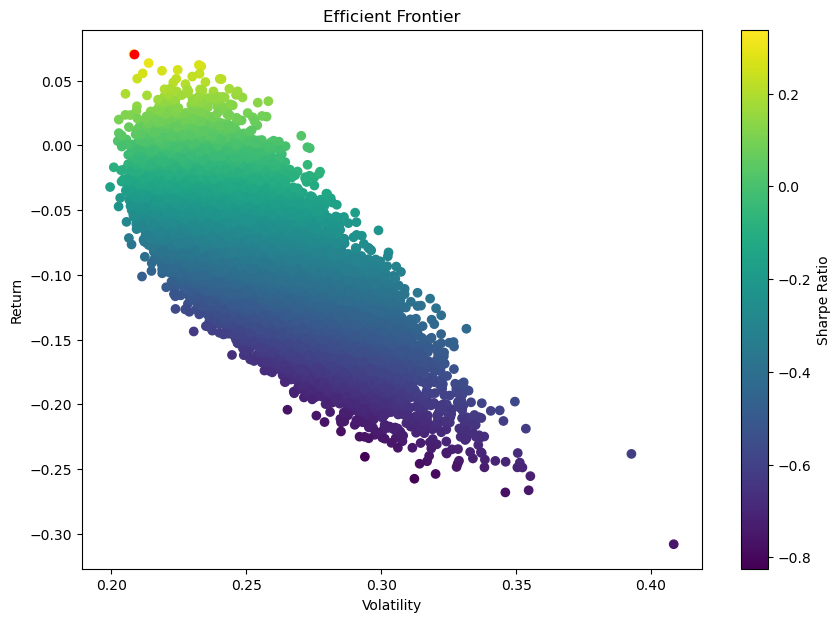

In [66]:

returns_array = np.array([portfolio_performance(w, retornos_anuais, cov_matrix)[0] for w in weights_record])
volatility_array = np.array([portfolio_performance(w, retornos_anuais, cov_matrix)[1] for w in weights_record])

plt.figure(figsize=(10, 7))
plt.scatter(volatility_array, returns_array, c=sharpe_array, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(volatility_array[best_portfolio_idx], returns_array[best_portfolio_idx], color='r')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

              Peso
PETR4.SA  0.188848
ENEV3.SA  0.020138
UGPA3.SA  0.035720
VALE3.SA  0.064994
CMIN3.SA  0.029383
ITUB4.SA  0.077654
BBAS3.SA  0.174142
BBDC4.SA  0.015198
MGLU3.SA  0.012907
VIIA3.SA  0.001701
JBSS3.SA  0.128628
BRFS3.SA  0.018922
ABEV3.SA  0.231764


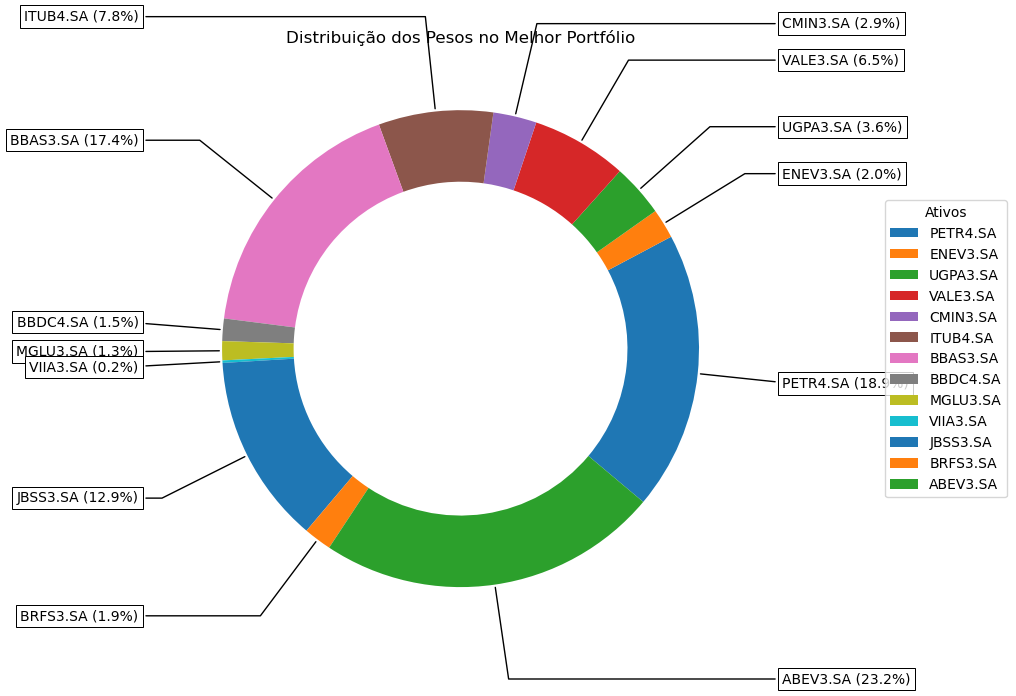

In [67]:
# In[17]:
import pandas as pd
import matplotlib.pyplot as plt

# Cria um dataframe pandas com os pesos do melhor portfólio
weights_df = pd.DataFrame(best_weights, index=retornos_anuais.index, columns=['Peso'])

# Printa o dataframe como uma tabela
print(weights_df)

# Cria um gráfico de pizza dos pesos
fig, ax = plt.subplots(figsize=(10,7))
wedges, texts = ax.pie(weights_df['Peso'], wedgeprops=dict(width=0.3), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(retornos_anuais.index[i] + f" ({weights_df['Peso'][i]*100:.1f}%)", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Distribuição dos Pesos no Melhor Portfólio")
plt.legend(wedges, retornos_anuais.index,
          title="Ativos",
          loc="center left",
          bbox_to_anchor=(1.2, 0, 0.5, 1))
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


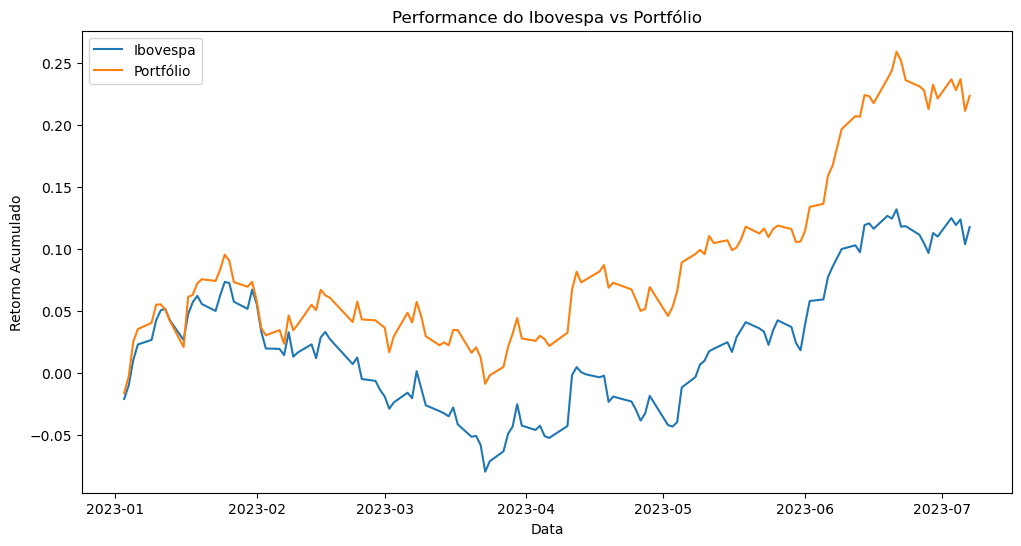

In [68]:
# Download dos dados do Ibovespa
ibov = yf.download('^BVSP', start='2023-01-01', end='2023-07-09')

# Cálculo dos retornos diários do Ibovespa
ibov['Retorno'] = ibov['Adj Close'].pct_change()

# Remover a primeira linha (que contém NaN devido ao cálculo do retorno)
ibov = ibov.dropna()

# Download dos dados dos ativos do portfólio para o mesmo período
dados_portf = {}
for ativo in retornos_anuais.index:
    dados_portf[ativo] = yf.download(ativo, start='2023-01-01', end='2023-07-09')
    dados_portf[ativo]['Retorno'] = dados_portf[ativo]['Adj Close'].pct_change()
    dados_portf[ativo] = dados_portf[ativo].dropna()

# Cálculo dos retornos diários do portfólio
retornos_portf = pd.DataFrame(index=ibov.index)
for ativo in retornos_anuais.index:
    retornos_portf[ativo] = dados_portf[ativo]['Retorno'] * best_weights[retornos_anuais.index.to_list().index(ativo)]

retornos_portf['Retorno Total'] = retornos_portf.sum(axis=1)

# Cálculo dos retornos acumulados
ibov['Retorno Acumulado'] = (1 + ibov['Retorno']).cumprod() - 1
retornos_portf['Retorno Acumulado'] = (1 + retornos_portf['Retorno Total']).cumprod() - 1

# Comparação da performance do portfólio e do Ibovespa
plt.figure(figsize=(12,6))
plt.plot(ibov['Retorno Acumulado'], label='Ibovespa')
plt.plot(retornos_portf['Retorno Acumulado'], label='Portfólio')
plt.title('Performance do Ibovespa vs Portfólio')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.show()


In [69]:
# Calcular o retorno do portfólio
retorno_portf = np.dot(best_weights, retornos_anuais)

# Calcular o risco do portfólio
risco_portf = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix, best_weights)))

# Print do risco e retorno do portfólio
print(f"Retorno do Portfólio: {retorno_portf}")
print(f"Risco do Portfólio: {risco_portf}")


Retorno do Portfólio: 0.070360356446517
Risco do Portfólio: 0.20822318607051796
